In [59]:
# 버전 확인 
import os
import pandas as pd
import konlpy
import gensim
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import tensorflow as tf

print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


1) 데이터 준비 및 확인

In [61]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [62]:
train_data.shape, test_data.shape

((150000, 3), (50000, 3))

2) 데이터 로더 구성

- 중복 데이터 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전 word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [63]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# def (list_of_sentences):
#     word_list = []
#     for sentence in train_data['document']:
#         temp = tokenizer.morphs(sentence)   # 토큰화
#         temp = [word for word in temp if word not in stopwords]   # 불용어 제거
#         word_list.append(temp)
#     return word_list
    

def load_data(train_data, test_data, num_words):
    
    # 'document'열을 기준으로 중복 제거 후 train_data 데이터 대체
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')    # NaN 제거

    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')     
    
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)   # 토큰화
        temp_X = [word for word in temp_X if word not in stopwords]   # 불용어 제거
        X_train.append(temp_X)

    X_test = []    
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)   # 토큰화
        temp_X = [word for word in temp_X if word not in stopwords]   # 불용어 제거
        X_test.append(temp_X)
        
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
            
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
      
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data, 10000)

In [64]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [65]:
# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}



print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index[index_to_word[4]])  # 4 이 출력됩니다. 
print(index_to_word[4])     # 'the' 가 출력됩니다.

# 보정 후 x_train[0] 데이터
print(get_decoded_sentence(x_train[0], index_to_word))

<BOS>
4
.
더 빙 . . 진짜 짜증 나 네요 목소리


In [72]:
print(word_to_index[index_to_word[11]])  # 4 이 출력됩니다. 
print(index_to_word[11])     # 'the' 가 출력됩니다.

11
..


3) 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [66]:
total_data_text = list(x_train) + list(x_test)
# 텍스트 데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 분포 (평균값, 최대값, 표준편차)를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [67]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape, x_test.shape)

(146182, 41) (49157, 41)


4) 모델 구성 및 validation set 구성

In [68]:
def split_validation_set(x_train, y_train, num_of_validation):
    """
    num_of_validation: validataion set 크기
    """
    # validation set 10000건 분리
    x_val = x_train[:num_of_validation]   
    y_val = y_train[:num_of_validation]

    # validation set을 제외한 나머지 15000건
    partial_x_train = x_train[num_of_validation:]  
    partial_y_train = y_train[num_of_validation:]

    print(partial_x_train.shape)
    print(partial_y_train.shape)
    return partial_x_train, partial_y_train, x_val, y_val


In [69]:
# 검증 세트 구성

N = 30000   # 검증세트 크기
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

partial_x_train, partial_y_train, x_val, y_val = split_validation_set(x_train, y_train, N)

(116182, 41)
(116182,)


In [76]:
# 모델 설정

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

vocab_size = len(word_to_index)
word_vector_dim = maxlen    # 위 그림과 같이 4차원의 워드 벡터를 가정합니다. 

# embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# # 숫자로 변환된 텍스트 데이터 [[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 에 Embedding 레이어를 적용합니다. 
# raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype='object')
# output = embedding(raw_inputs)


model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 41)          410205    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1600      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 411,886
Trainable params: 411,886
Non-trainable params: 0
_________________________________________________________________


In [77]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
286/286 [==============================] - 6s 7ms/step - loss: 0.4513 - accuracy: 0.8086 - val_loss: 0.3213 - val_accuracy: 0.8682
Epoch 2/20
286/286 [==============================] - 1s 5ms/step - loss: 0.3292 - accuracy: 0.8604 - val_loss: 0.2928 - val_accuracy: 0.8798
Epoch 3/20
286/286 [==============================] - 1s 5ms/step - loss: 0.3072 - accuracy: 0.8699 - val_loss: 0.2771 - val_accuracy: 0.8847
Epoch 4/20
286/286 [==============================] - 1s 5ms/step - loss: 0.2925 - accuracy: 0.8761 - val_loss: 0.2686 - val_accuracy: 0.8885
Epoch 5/20
286/286 [==============================] - 1s 5ms/step - loss: 0.2792 - accuracy: 0.8816 - val_loss: 0.2568 - val_accuracy: 0.8943
Epoch 6/20
286/286 [==============================] - 1s 5ms/step - loss: 0.2652 - accuracy: 0.8876 - val_loss: 0.2367 - val_accuracy: 0.9034
Epoch 7/20
286/286 [==============================] - 1s 5ms/step - loss: 0.2505 - accuracy: 0.8943 - val_loss: 0.2241 - val_accuracy: 0.9101
Epoch 

In [78]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5426 - accuracy: 0.8366
[0.5426317453384399, 0.8366051912307739]


In [79]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


6) 손실, 정확도 시각화

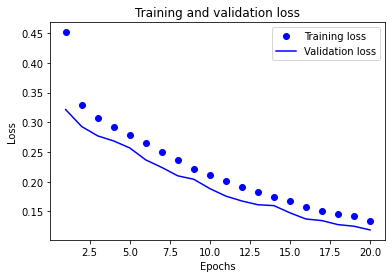

In [81]:

def draw_graph(history_dict):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
draw_graph(history_dict)

In [88]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path = os.getenv('HOME')+'word2vec_ko.model'
# limit = None으로 하면 워드 벡터에 있는 모든 단어(300만개) 사용
word_vectors = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors.wv["끝"]
# vector     # 무려 300dim의 워드 벡터입니다.

FileNotFoundError: [Errno 2] No such file or directory: '/aiffelword2vec_ko.model'

In [74]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]
        
embedding_matrix[0]

AttributeError: 'KeyedVectors' object has no attribute 'wv'

In [23]:
embedding_matrix[10]

array([-0.02368164,  0.10791016, -0.13574219, -0.20605469, -0.02270508,
        0.08349609,  0.0177002 , -0.17578125,  0.0123291 ,  0.28515625,
       -0.19140625, -0.33789062, -0.07910156, -0.03295898, -0.00485229,
        0.06079102,  0.18457031,  0.27734375, -0.22949219,  0.02600098,
       -0.0378418 , -0.24511719,  0.42382812, -0.03759766, -0.32421875,
        0.13085938, -0.3046875 , -0.00897217, -0.06445312,  0.06445312,
       -0.04931641, -0.02954102, -0.33984375, -0.51953125, -0.16992188,
       -0.11767578, -0.2734375 ,  0.27929688, -0.01623535,  0.09277344,
       -0.07714844, -0.23535156, -0.03613281,  0.16308594,  0.32421875,
        0.08398438, -0.11572266, -0.28125   , -0.12207031, -0.06689453,
        0.21679688,  0.12158203, -0.00994873,  0.00166321, -0.04931641,
       -0.006073  , -0.2734375 , -0.02526855, -0.04150391, -0.18652344,
       -0.0402832 ,  0.17578125, -0.16699219, -0.06054688, -0.15917969,
       -0.04858398,  0.11914062,  0.04614258,  0.01843262, -0.01

In [22]:
embedding_matrix.shape

(10000, 300)

In [31]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 580, 300)          3000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 574, 16)           33616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 114, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 108, 16)           1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [32]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 3s 83ms/step - loss: 0.6993 - accuracy: 0.5021 - val_loss: 0.6930 - val_accuracy: 0.5334
Epoch 2/20
30/30 [==============================] - 2s 70ms/step - loss: 0.6859 - accuracy: 0.5518 - val_loss: 0.6828 - val_accuracy: 0.5692
Epoch 3/20
30/30 [==============================] - 2s 71ms/step - loss: 0.6659 - accuracy: 0.6045 - val_loss: 0.6657 - val_accuracy: 0.5918
Epoch 4/20
30/30 [==============================] - 2s 71ms/step - loss: 0.6036 - accuracy: 0.7077 - val_loss: 0.5694 - val_accuracy: 0.7460
Epoch 5/20
30/30 [==============================] - 2s 71ms/step - loss: 0.4498 - accuracy: 0.8247 - val_loss: 0.4359 - val_accuracy: 0.8034
Epoch 6/20
30/30 [==============================] - 2s 71ms/step - loss: 0.3082 - accuracy: 0.8834 - val_loss: 0.3822 - val_accuracy: 0.8274
Epoch 7/20
30/30 [==============================] - 2s 72ms/step - loss: 0.2213 - accuracy: 0.9216 - val_loss: 0.3359 - val_accuracy: 0.8586
Epoch 8/20
30

In [33]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)
# 782/782 - 2s - loss: 0.6300 - accuracy: 0.8438

history_dict = history.history
# print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
# dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

782/782 - 2s - loss: 0.6300 - accuracy: 0.8438
[0.6299698948860168, 0.8438000082969666]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
